# Showing Word2Vec encoding limitations

In [1]:
from collections import defaultdict

# RCVDB: Dictionary only needs to keep track of the unique values of a single attribute
class AttributeDictionary():
    def __init__(self, max_size=100) -> None:
        self.max_size = max_size
        self.encodings = defaultdict(str)
        self.encodings_inv = defaultdict(int)

    def encode(self, label):
        if label in self.encodings.keys():
            return str(self.encodings[label])
        else:
            existing_keys = self.encodings_inv.keys()
            new_key = len(existing_keys)
            self.encodings[label] = new_key
            self.encodings_inv[new_key] = label
            return str(new_key)
        
    def decode(self, value):
        value = int(value)
        if value in self.encodings_inv.keys():
            return self.encodings_inv[value]
        else:
            return None
        
    def encoded_attributes(self):
        return [str(i) for i in map(str, self.encodings_inv.keys())]
    
    # Buffer attributes are all encoded labels that are not part of a label_value mapping
    def buffer_attributes(self):
        current_size = len(self.encodings_inv.keys())
        return [str(i) for i in range(current_size, self.max_size)]

In [2]:
all_attributes = ["red", "blue", "green", "yellow", "purple", "orange", "pink", "brown", "gray", "black"]
unknown_attributes = ["cyan", "magenta", "teal", "lavender", "beige"]

In [3]:
attrDict = AttributeDictionary(max_size=100)
for att in all_attributes:
    attrDict.encode(att)

print(all_attributes)

encoded_attributes = attrDict.encoded_attributes()
buffer_attributes = attrDict.buffer_attributes()

print(encoded_attributes)

decoded_attributes = []
for val in encoded_attributes:
    decoded_attributes.append(attrDict.decode(val[0]))

print(decoded_attributes)

print(encoded_attributes + buffer_attributes)

['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'black']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'black']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [4]:
from gensim.models import Word2Vec

def convert_to_sentences(input):
    return [[str(i)] for i in input]

buffered_w2v_model = Word2Vec(sentences=convert_to_sentences(encoded_attributes + buffer_attributes), vector_size=15, window=5, min_count=1)
unbuffered_w2v_model = Word2Vec(sentences=convert_to_sentences(encoded_attributes), vector_size=15, window=5, min_count=1)

In [5]:
# Encoding the known words
buff_w2v_encodings = []
unbuff_w2v_encodings = []
for attr in encoded_attributes:
    buff_w2v_encodings.append(buffered_w2v_model.wv[attr])
    unbuff_w2v_encodings.append(unbuffered_w2v_model.wv[attr])

In [6]:
unknown_attribute = unknown_attributes[0]
enc_unkown_attribute = attrDict.encode(unknown_attribute)

print(unknown_attribute, enc_unkown_attribute)

cyan 10


In [7]:
# Cant deal with unknown values
try:
    unbuffered_w2v_model.wv[enc_unkown_attribute]
except KeyError as e:
    print(e, 'in the unbuffered w2v')
try:
    buffered_w2v_model.wv[unknown_attribute]
except KeyError as e: 
    print(e, 'in the buffered (and unbufferd) w2v')

# But can deal with the encoded unknown value if buffered
try:
    w2v_unknown_attribute = buffered_w2v_model.wv[enc_unkown_attribute]
    print(enc_unkown_attribute, 'is present in the buffered w2v')
    print(w2v_unknown_attribute)
except KeyError as e:
    print(e)

# Find the most similar words to the unknown vector
similar_words = buffered_w2v_model.wv.similar_by_vector(w2v_unknown_attribute)

# Note that the 10 (cyan) has a 100% match while it is not in the original dataset
print(similar_words)

best_match = similar_words[0][0]
print(attrDict.decode(best_match))

"Key '10' not present" in the unbuffered w2v
"Key 'cyan' not present" in the buffered (and unbufferd) w2v
10 is present in the buffered w2v
[ 0.01630844  0.06603314 -0.05110536 -0.04644613 -0.05157678  0.05597282
 -0.00454224  0.06096273 -0.05438814  0.0249539   0.01756695  0.00495142
  0.01551784 -0.04979396 -0.06238916]
[('10', 1.0), ('20', 0.8249238729476929), ('21', 0.760670006275177), ('36', 0.695140540599823), ('28', 0.5168521404266357), ('97', 0.501341700553894), ('91', 0.47365880012512207), ('14', 0.41315966844558716), ('79', 0.36295434832572937), ('67', 0.35488972067832947)]
cyan


# Label Encoder has the same problem
Thus a dictionary keeping track of the attributes is also needed

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
all_attributes_encoded = encoder.fit_transform(all_attributes)

print(all_attributes_encoded)

[8 1 4 9 7 5 6 2 3 0]


In [9]:
# Cant deal with unknown values
try:
    encoder.transform(unknown_attributes)
except ValueError as e:
    print(e)

y contains previously unseen labels: 'cyan'


# Word2Vec Wrapper

In [10]:
import numpy as np

class ProcessWord2Vec():
    def __init__(self, training_sentances) -> None:
        self.w2v_model = Word2Vec(sentences=training_sentances, vector_size=50, window=5, min_count=1, workers=4)

    # Function to get the Word2Vec vector for an attribute
    def _get_attr_vector(self, attr):
        return self.w2v_model.wv[attr]

    # Function to encode an event by averaging its attribute vectors
    def encode_event(self, event):
        attribute_vectors = np.array([get_attr_vector(attr) for attr in event])
        event_vector = np.mean(attribute_vectors, axis=0)
        return event_vector

    # Function to encode a trace by concatenating its event vectors
    def encode_trace(self, trace):
        event_vectors = [self.encode_event(event) for event in trace]
        trace_vector = np.concatenate(event_vectors, axis=0)
        return trace_vector      

In [20]:
import random

all_attributes = ["red", "blue", "green", "yellow", "purple", "orange", "pink", "brown", "gray", "black"]

# Create traces with random selection of attributes
length = 10
size = 100
attribute_traces = [random.sample(all_attributes, length) for _ in range(size)]
unique_attributes = list(set(attribute for sublist in attribute_traces for attribute in sublist))
print(attribute_traces)

# Convert the traces labels to integers
attrDict = AttributeDictionary(max_size=100)
for i, trace in enumerate(attribute_traces):
    for j, attribute in enumerate(trace):
        attribute_traces[i][j] = attrDict.encode(attribute)
print(attribute_traces)

# Append the buffer to the traces
# If some pre-existing data is available it can be used to improve the w2v training, however, in theory no pre-training is nessessary.
# In the latter case only the buffer is used exclusively
def convert_to_sentences(input):
    return [[str(i)] for i in input]
sentances_pre_training = attribute_traces + convert_to_sentences(attrDict.buffer_attributes())
print(sentances_pre_training)

no_pretrain_attrDict = AttributeDictionary(max_size=100)
scentences_only_buffer = convert_to_sentences(no_pretrain_attrDict.buffer_attributes())
print(scentences_only_buffer)

# The w2v model can then be trained on any existing traces and the generic buffer
process_w2v_model = ProcessWord2Vec(training_sentances=sentances_pre_training)
process_w2v_model_only_buffer = ProcessWord2Vec(training_sentances=scentences_only_buffer)

[['pink', 'brown', 'orange', 'red', 'gray', 'purple', 'blue', 'yellow', 'black', 'green'], ['blue', 'pink', 'purple', 'green', 'black', 'brown', 'gray', 'yellow', 'red', 'orange'], ['purple', 'green', 'blue', 'brown', 'red', 'black', 'yellow', 'gray', 'orange', 'pink'], ['black', 'gray', 'red', 'purple', 'pink', 'brown', 'green', 'yellow', 'orange', 'blue'], ['red', 'black', 'blue', 'pink', 'orange', 'brown', 'purple', 'green', 'yellow', 'gray'], ['orange', 'yellow', 'pink', 'gray', 'black', 'red', 'purple', 'blue', 'brown', 'green'], ['pink', 'yellow', 'blue', 'red', 'green', 'orange', 'purple', 'brown', 'black', 'gray'], ['black', 'orange', 'gray', 'pink', 'brown', 'purple', 'yellow', 'green', 'red', 'blue'], ['pink', 'yellow', 'brown', 'red', 'green', 'blue', 'gray', 'orange', 'purple', 'black'], ['blue', 'gray', 'red', 'yellow', 'orange', 'pink', 'brown', 'green', 'black', 'purple'], ['blue', 'gray', 'green', 'yellow', 'purple', 'pink', 'orange', 'brown', 'red', 'black'], ['orange'

## Visualizing the encoding

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def reduce_embedding_space(w2v_model):
    words = list(w2v_model.wv.key_to_index.keys())
    word_vectors = np.array([w2v_model.wv[word] for word in words])

    pca = PCA(n_components=2)
    word_vectors_2d = pca.fit_transform(word_vectors)

    # tsne = TSNE(n_components=2, random_state=2024)
    # word_vectors_2d = tsne.fit_transform(word_vectors)

    return words, word_vectors_2d

words, word_vectors_2d = reduce_embedding_space(process_w2v_model.w2v_model)
words_only_buffer, word_vectors_2d_only_buffer = reduce_embedding_space(process_w2v_model_only_buffer.w2v_model)

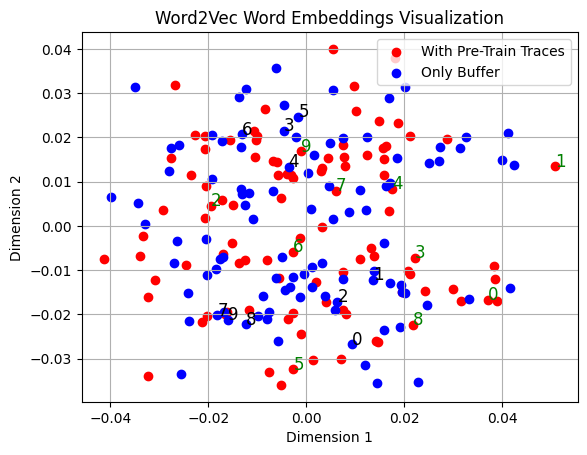

In [25]:

# Plot each category with different colors
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], color='red', label='With Pre-Train Traces')
plt.scatter(word_vectors_2d_only_buffer[:, 0], word_vectors_2d_only_buffer[:, 1], color='blue', label='Only Buffer')

# Annotate the points with the corresponding words
for i, word in enumerate(words):
    if int(word) < 10:
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=12, color='green')

for i, word in enumerate(words_only_buffer):
    if int(word) < 10:
        plt.annotate(word, xy=(word_vectors_2d_only_buffer[i, 0], word_vectors_2d_only_buffer[i, 1]), fontsize=12, color='black')

# Set the title and labels
plt.title('Word2Vec Word Embeddings Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid()
plt.legend()
plt.show()